In [1]:
# ======================================
# 0. Core libs (DAY1~DAY9 공통)
# ======================================
import numpy as np
import pandas as pd

import shutil
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
import matplotlib.font_manager as fm
from matplotlib import rcParams

# ======================================
# 1) Style FIRST (폰트보다 먼저)
# ======================================
plt.style.use("_mpl-gallery-nogrid")
sns.set_theme(style="white")
sns.set_style("ticks")
sns.set_context("notebook")

# ======================================
# 2) Font (NanumGothic) — style 적용 후 "고정"
# ======================================
FONT_DIR = Path(r"E:\Portfolio_ver1\seoul_pv_load_analysis\fonts")
FONT_PATH = FONT_DIR / "NanumGothic.ttf"

if not FONT_PATH.exists():
    raise FileNotFoundError(f"폰트 파일 없음: {FONT_PATH}")

fm.fontManager.addfont(str(FONT_PATH))
font_name = fm.FontProperties(fname=str(FONT_PATH)).get_name()

rcParams["font.family"] = font_name
rcParams["axes.unicode_minus"] = False

# (선택) 기본 글자 크기 통일
rcParams["font.size"] = 12
rcParams["axes.titlesize"] = 18
rcParams["axes.labelsize"] = 14
rcParams["xtick.labelsize"] = 12
rcParams["ytick.labelsize"] = 12

# 개별 객체용 (필요할 때만)
font_prop = fm.FontProperties(fname=str(FONT_PATH))

print("✅ Style+Font ready:", font_name)

✅ Style+Font ready: NanumGothic


### DAY 6: 전력 운영 관점 해석

**목적**
- 분석 결과를 ESS·DR·분산자원 운영 판단으로 연결

**주요 작업**
- 개입 필요 시간대 해석
- 설비 확장 이전 운영 전략 논리 정리

**산출물**
- 운영 판단 시나리오 정리

# DAY 6 - Operation Scenario Interpretation

본 노트북은 DAY 1 ~ 5에서 생성한 분석 결과(CSV output)를 재사용하여,
전력 부하 - 태양광 간 시간대 불일치 구조를
전력 운영 관점(ESS, DR(수요 반응))의 의사결정 시나리오로 해석한다.

본 단계에서는 새로운 데이터 처리나 계산을 수행하지 않으며,
이미 도출된 결과를 기반으로 운영 판단 기준을 정리한다.

In [2]:
# 프로젝트 경로
PROJECT_ROOT = Path.cwd().parent
OUT_DIR = PROJECT_ROOT / "outputs"

# DAY 1 ~ 5 outputs 로드
load_profile = pd.read_csv(OUT_DIR / "DAY2_hourly_load_profile.csv")
pv_profile = pd.read_csv(OUT_DIR / "DAY3_pv_theoretical_profile.csv")
net_base = pd.read_csv(OUT_DIR / "DAY4_net_load_base.csv")
scenario_df = pd.read_csv(OUT_DIR / "DAY5_scenario_netload.csv")
metrics_df = pd.read_csv(OUT_DIR / "DAY5_metrics_summary.csv")

load_profile.head(), pv_profile.head(), metrics_df

(   hour    load_mean
 0     0  4828.966546
 1     1  4436.061656
 2     2  4301.931715
 3     3  4069.172541
 4     4  4467.956892,
    hour  pv_norm
 0     0      0.0
 1     1      0.0
 2     2      0.0
 3     3      0.0
 4     4      0.0,
    pv_ratio  evening_peak      net_min   duck_depth    max_ramp    min_ramp  \
 0       0.1   6972.052472  4069.172541  2902.879931  852.042482 -514.092136   
 1       0.2   6900.058323  4069.172541  2830.885783  805.502700 -514.092136   
 2       0.3   6828.064175  4069.172541  2758.891634  758.962919 -514.092136   
 3       0.4   6756.070027  4069.172541  2686.897486  764.058044 -704.610292   
 
    surplus_total  deficit_total pv_label  
 0            0.0  143606.488761   PV 10%  
 1            0.0  139216.955504   PV 20%  
 2            0.0  134827.422247   PV 30%  
 3            0.0  130437.888991   PV 40%  )

## Summary of Analysis Results (DAY 5)

- 태양광 비중이 증가할수록 낮 시간대 Net Load는 크게 감소하였다.
- 반면 저녁 시간대 (18 ~ 22시)의 Net Load는 상대적으로 유지되며,
- 낮 - 저녁 간 격차(Duck Depth)가 구조적으로 형성되었다.
- Ramp Rate는 단순히 PV 비중에 비례하지 않으며, 부하 곡선과 태양광 출력 패턴의 시간대 불일치에서 기안한다.

## Load–PV–Net Load Combined Profile (Conceptual)

Day 1~5 분석 결과를 바탕으로,
전력 수요(Load), 태양광 발전(PV), 그리고 순부하(Net Load = Load − PV)의
시간대 분포를 한 그래프에서 비교한다.

이 시각화는 덕 커브가 “발전량 부족”이 아니라
“시간대 불일치 구조”에서 발생한다는 점을 직관적으로 보여준다.

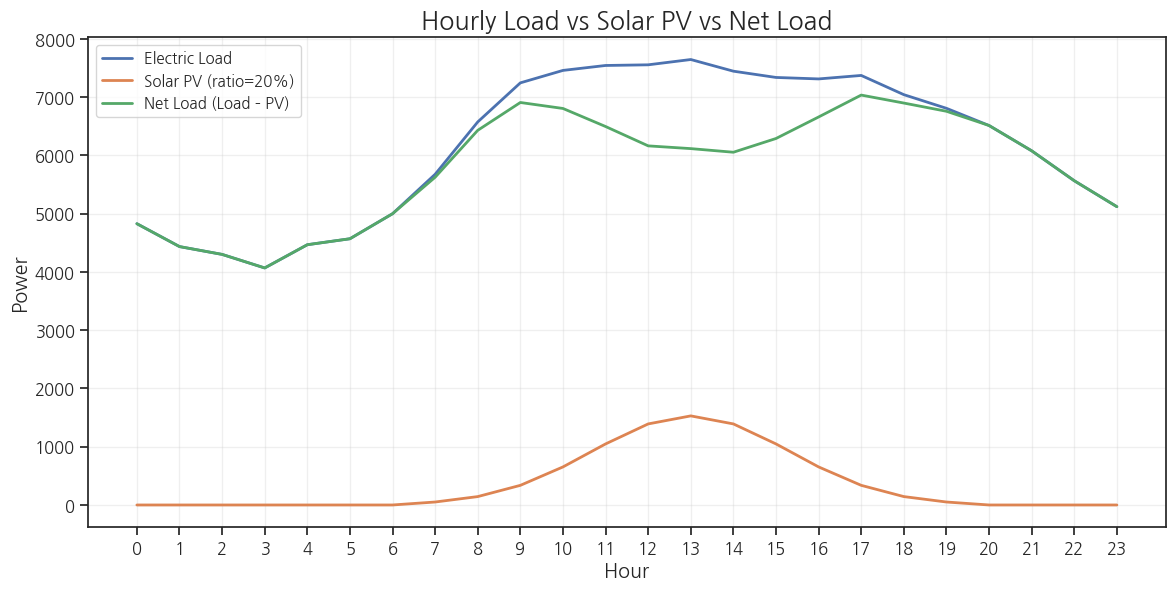

In [7]:
# 대표 시나리오 선택 (필요 시 0.10, 0.20, 0.30 등 변경)
target_ratio = 0.20

df_plot = scenario_df[scenario_df["pv_ratio"] == target_ratio].copy()
df_plot = df_plot.sort_values("hour")

# 안전장치: net_load가 없으면 계산해서 생성
if "net_load" not in df_plot.columns:
    df_plot["net_load"] = df_plot["load_mean"] - df_plot["pv_kW"]

plt.figure(figsize=(11, 5))
plt.plot(df_plot["hour"], df_plot["load_mean"], label="Electric Load", linewidth=2)
plt.plot(df_plot["hour"], df_plot["pv_kW"], label=f"Solar PV (ratio={int(target_ratio*100)}%)", linewidth=2)
plt.plot(df_plot["hour"], df_plot["net_load"], label="Net Load (Load – PV)", linewidth=2)

plt.xlabel("Hour")
plt.ylabel("Power")
plt.title("Hourly Load vs Solar PV vs Net Load")
plt.xticks(range(0, 24, 1))
plt.grid(alpha=0.3)
plt.legend()
plt.show()

### Interpretation

- 태양광 발전은 낮 시간대에 집중되어 Load를 일부 상쇄하지만,
  저녁 시간대(18–22시)에는 기여가 거의 없다.
- 그 결과 Net Load는 낮 시간대에 크게 감소하고,
  저녁 시간대에는 상대적으로 유지되면서
  낮–저녁 간 격차(duck depth)가 구조적으로 형성된다.
- 따라서 덕 커브는 “발전량 부족”이 아니라
  “수요–발전 시간대 불일치” 문제로 해석하는 것이 타당하다.

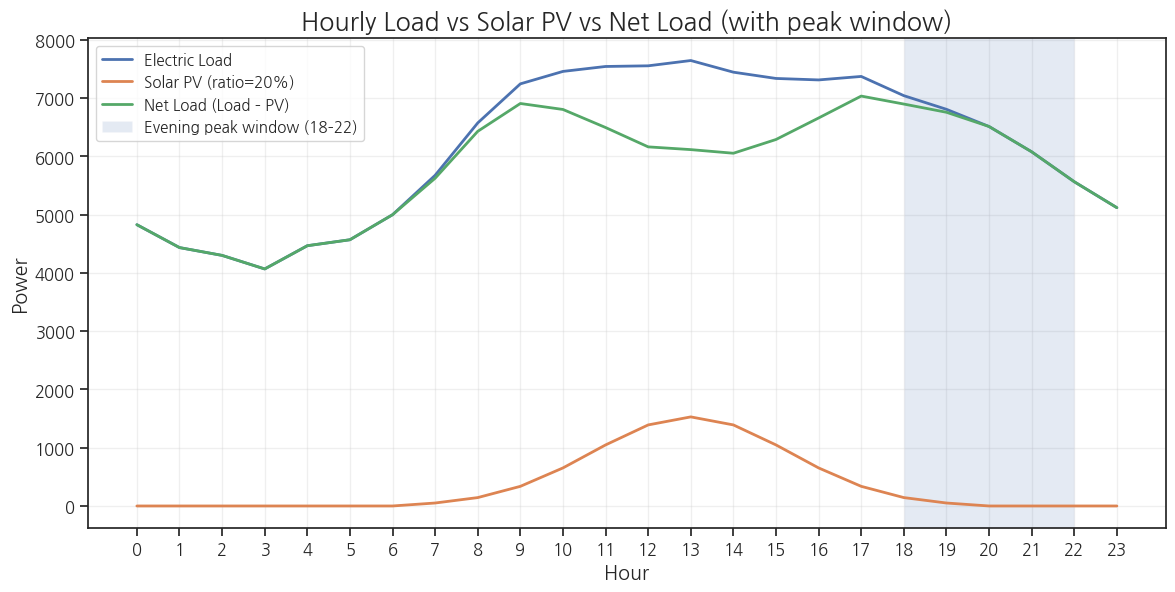

In [8]:
plt.figure(figsize=(11, 5))
plt.plot(df_plot["hour"], df_plot["load_mean"], label="Electric Load", linewidth=2)
plt.plot(df_plot["hour"], df_plot["pv_kW"], label=f"Solar PV (ratio={int(target_ratio*100)}%)", linewidth=2)
plt.plot(df_plot["hour"], df_plot["net_load"], label="Net Load (Load – PV)", linewidth=2)

# Evening peak window highlight
plt.axvspan(18, 22, alpha=0.15, label="Evening peak window (18–22)")

plt.xlabel("Hour")
plt.ylabel("Power")
plt.title("Hourly Load vs Solar PV vs Net Load (with peak window)")
plt.xticks(range(0, 24, 1))
plt.grid(alpha=0.3)
plt.legend()
plt.show()

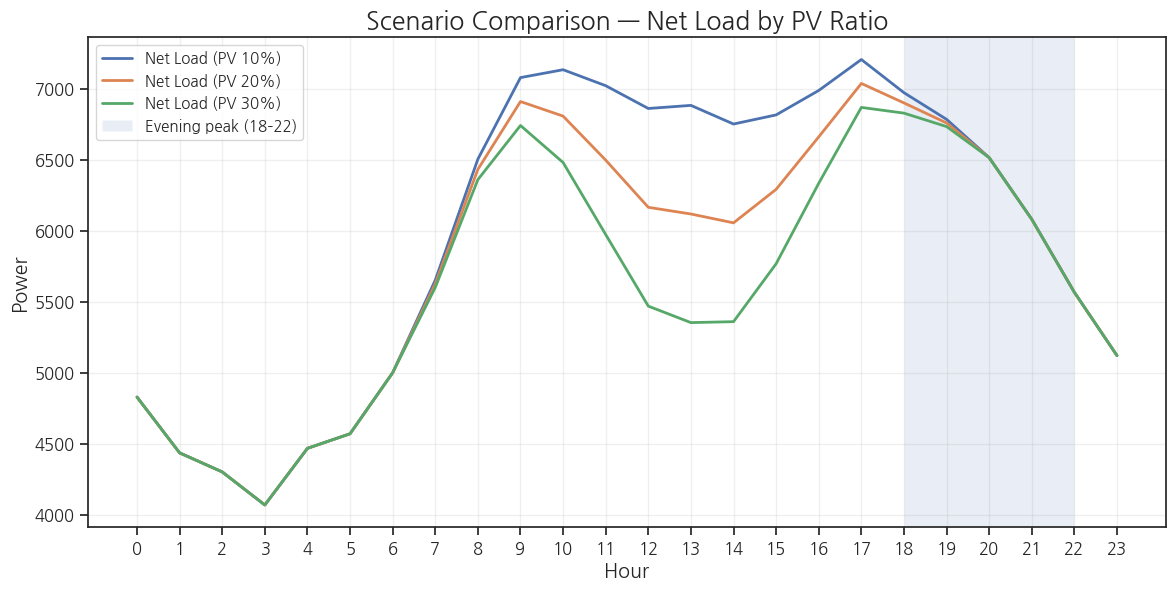

In [9]:
ratios = [0.10, 0.20, 0.30]

plt.figure(figsize=(11, 5))

for r in ratios:
    df = scenario_df[scenario_df["pv_ratio"] == r].copy().sort_values("hour")
    plt.plot(df["hour"], df["net_load"], linewidth=2, label=f"Net Load (PV {int(r*100)}%)")

plt.axvspan(18, 22, alpha=0.12, label="Evening peak (18–22)")

plt.xlabel("Hour")
plt.ylabel("Power")
plt.title("Scenario Comparison — Net Load by PV Ratio")
plt.xticks(range(0, 24, 1))
plt.grid(alpha=0.3)
plt.legend()
plt.show()

PV 비중이 증가할수록 낮 시간대 Net Load는 감소하지만,
저녁 피크 구간(18–22시)의 Net Load는 상대적으로 유지되어
낮–저녁 간 격차(덕 커브)가 구조적으로 나타난다.

In [10]:
# 위험 시간대 자동 식별
target_ratio = 0.20

df_risk = scenario_df[scenario_df["pv_ratio"] == target_ratio].copy()
df_risk = df_risk.sort_values("hour")

# Evening Peak
evening_peak_hour = (
    df_risk.loc[df_risk["hour"].between(18, 22)].sort_values("net_load", ascending = False).iloc[0]["hour"])

# Ramp
df_risk["ramp"] = df_risk["net_load"].diff()
max_ramp_hour = df_risk.sort_values("ramp", ascending = False).iloc[0]["hour"]

evening_peak_hour, max_ramp_hour

(np.float64(18.0), np.float64(8.0))

## ESS Operation Scenario

ESS는 발전량 확대 수단이 아니라, 시간대 불일치를 완화하는 운영 장치로 해석한다.

- 충전(Charge):
  - 태양광 출력이 높은 낮 시간대
  - Net Load가 최소가 되는 구간

- 방전(Discharge):
  - Evening peak 시간대 (18 ~ 22시)
  - Ramp가 크게 발생하는 구간 

In [11]:
# ESS 충·방전 로직 표현

df_ess = df_risk.copy()

df_ess["ESS_action"] = "Idle"
df_ess.loc[df_ess["pv_norm"] > 0.7, "ESS_action"] = "Charge"
df_ess.loc[df_ess["hour"].between(18, 22), "ESS_action"] = "Discharge"

df_ess[["hour", "net_load", "ESS_action"]]

,hour,net_load,ESS_action
24,0,4828.966546,Idle
25,1,4436.061656,Idle
26,2,4301.931715,Idle
27,3,4069.172541,Idle
28,4,4467.956892,Idle
29,5,4570.492076,Idle
30,6,5000.093613,Idle
31,7,5626.501187,Idle
32,8,6432.003887,Idle
33,9,6909.696478,Idle


## Demand Response (DR, 수요 반응) Perspective

DR은 총 전력 소비 절감이 아니라, 전력 수요의 시간대 이동 수단으로 해석된다.

- 개입 시점: Evening Peak 직전 및 초입
- 기대 효과: Peak 절대값 감소보다는 Ramp 완화 및 계통 안전성 확보

In [12]:
# 운영 판단 요약 테이블
summary = {
    "PV scenario": f"{int(target_ratio * 100)}%",
    "Evening Peak Hour": int(evening_peak_hour),
    "Max Ramp Hour": int(max_ramp_hour),
    "ESS Charge Window": "High PV output hours",
    "ESS Discharge Window": "18 ~ 22",
    "DR Target Window": "Pre-peak / Peak start"}

pd.DataFrame(summary.items(), columns = ["Item", "Description"])

,Item,Description
0,PV scenario,20%
1,Evening Peak Hour,18
2,Max Ramp Hour,8
3,ESS Charge Window,High PV output hours
4,ESS Discharge Window,18 ~ 22
5,DR Target Window,Pre-peak / Peak start



## Capacity Expansion (설비 확대) VS Operational Shift (운영 전환)

태양광 설비 확대는 낮 시간대 잉여를 증가시키지만,
덕 커브의 구조적 원인을 직접적으로 해결하지는 못한다.

반면, ESS 및 DR 기반 운영 전략은 기존 설비를 활용하여 시간대 불일치를 완화할 수 있다.

본 분석은 재생에너지 확대와 함께 운영 전략 병행의 필요성을 시사한다.

## DAY6 Conclusion

덕 커브 현상은 재생에너지의 실패가 아니라,
전력 수요와 발전 간 시간대 불일치에서 기인한 구조적 결과이다.

따라서 향후 전력시스템은 설비 확장 중심 접근을 넘어,
저장·제어·수요 관리 기반의 운영 전략을 핵심 축으로 가져가야 한다.